In [3]:
!sudo apt-get update
!pip install tf-agents[reverb]
!pip install pandas
!pip install numpy
!pip install pandas_ta

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]                
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Get:3 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [998 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,137 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1,792 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,014 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.0 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
Get:12 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:13 http://archi

2023-09-27 03:56:26.981754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 03:56:27.023681: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 03:56:27.025643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 03:56:28.047394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp20qalw3j.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp20qalw3j
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44185
[reverb/cc

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000: loss = 212413056.0


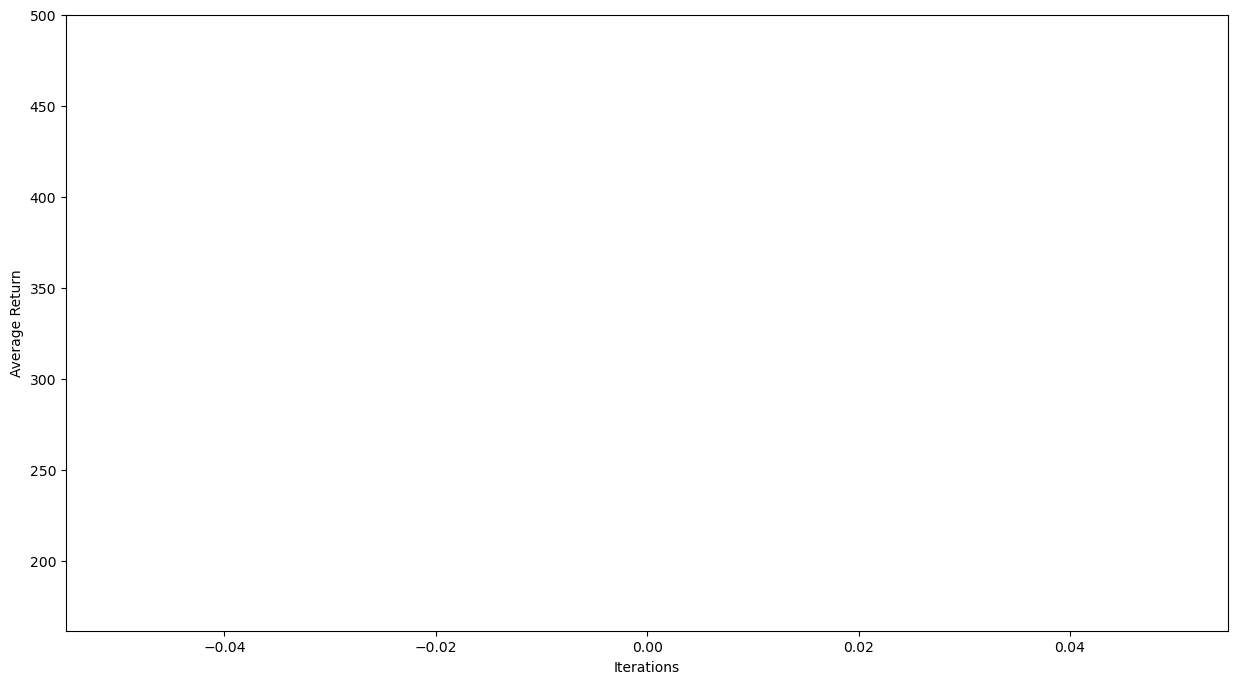

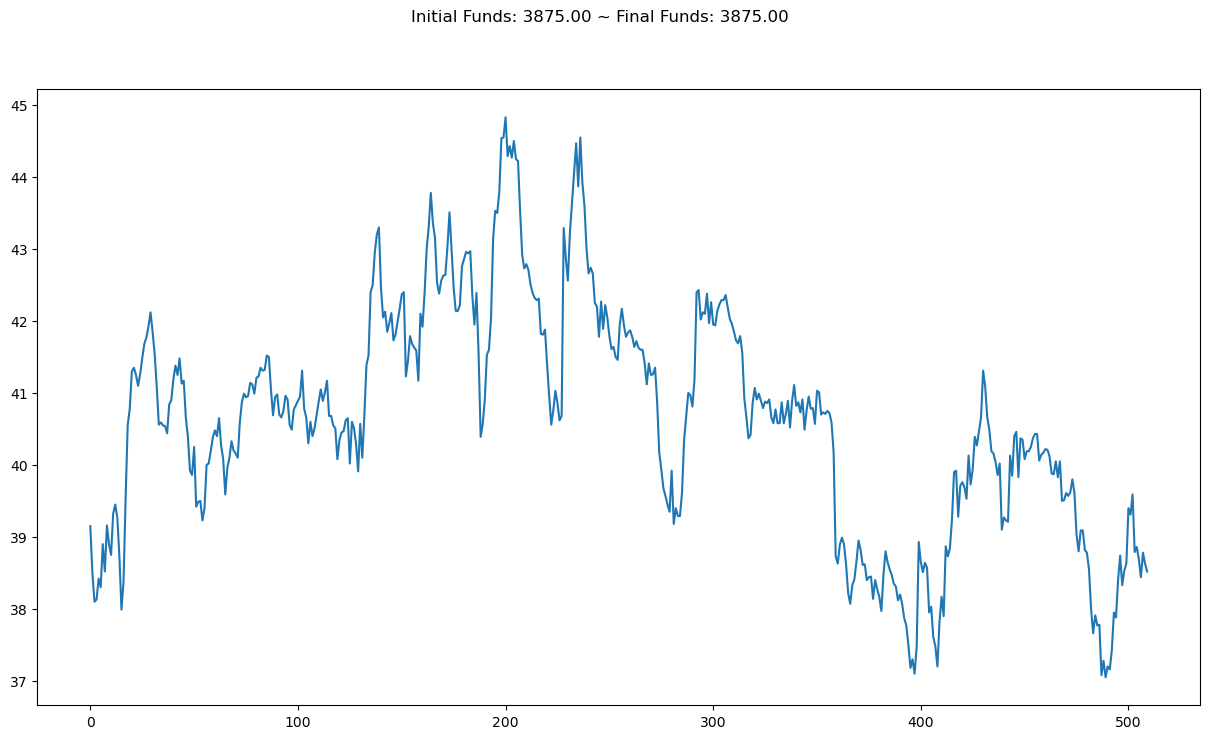

In [4]:
from __future__ import absolute_import, division, print_function

import base64
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import reverb
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from airtos.envs import MacdEnv, AdxEnv, RsiEnv, MovingAverageEnv, CombinedEnv
from airtos.utils import load_dataset

import sys


def layers_cfg(id: str):
    return {
        'v1': (100, 50),
        'v2': (100, 100),
        'v3': (50, 50),
        'v4': (50, 100),
    }.get(id)


DEFINED_ENVS = ['macd', 'rsi', 'adx', 'mix', 'mas']


def parse_args(args_arr):
    num_iterations = None
    learning_rate = None
    env_type = None
    agent_layers = None
    run_id = None

    learning_rate_str = ''
    agent_layers_str = ''

    for s in args_arr:
        if s.startswith('NUMIT='):
            num_iterations = int(s.removeprefix('NUMIT='))
        elif s.startswith('LRATE='):
            learning_rate = float(s.removeprefix('LRATE='))
            learning_rate_str = s.removeprefix('LRATE=').replace('.', '_')
        elif s.startswith('ENV='):
            env_type = s.removeprefix('ENV=')
        elif s.startswith('LAYERS='):
            agent_layers = layers_cfg(s.removeprefix('LAYERS='))
            agent_layers_str = s.removeprefix('LAYERS=')

    assert type(num_iterations) == int and num_iterations > 0
    assert type(learning_rate) == float and learning_rate > 0
    assert env_type in DEFINED_ENVS
    assert type(agent_layers) == tuple and len(agent_layers) > 0

    run_id = f'{num_iterations}_{env_type}_{agent_layers_str}_{learning_rate_str}'
    return (num_iterations, learning_rate, env_type, agent_layers, run_id)


def create_environments(env_type: str, filename: str):
    df = load_dataset(filename)
    window_size = 10
    train_bounds = (10, 2000)
    eval_bounds = (2000, 2500)

    if env_type == 'macd':
        train_env = MacdEnv(df=df, window_size=window_size,
                            frame_bound=train_bounds)
        eval_env = MacdEnv(df=df, window_size=window_size,
                           frame_bound=eval_bounds)
    elif env_type == 'rsi':
        train_env = RsiEnv(df=df, window_size=window_size,
                           frame_bound=train_bounds)
        eval_env = RsiEnv(df=df, window_size=window_size,
                          frame_bound=eval_bounds)
    elif env_type == 'adx':
        train_env = AdxEnv(df=df, window_size=window_size,
                           frame_bound=train_bounds)
        eval_env = AdxEnv(df=df, window_size=window_size,
                          frame_bound=eval_bounds)
    elif env_type == 'mas':
        train_env = MovingAverageEnv(
            df=df, window_size=window_size, frame_bound=train_bounds)
        eval_env = MovingAverageEnv(
            df=df, window_size=window_size, frame_bound=eval_bounds)
    else:
        train_env = CombinedEnv(
            df=df, window_size=window_size, frame_bound=train_bounds)
        eval_env = CombinedEnv(
            df=df, window_size=window_size, frame_bound=eval_bounds)

    return (train_env, eval_env)


# ====================================== Parse arguments and extract params ======================================
args = sys.argv[1:]
args = ["NUMIT=1000","LRATE=0.003","LAYERS=v1", "ENV=macd"]

num_iterations, learning_rate, env_type, agent_layers, run_id = parse_args(
    args)

# num_iterations = 50000
initial_collect_steps = 1000
collect_steps_per_iteration = 5
replay_buffer_max_length = 100000
batch_size = 64
# learning_rate = 0.003
log_interval = 1000
num_eval_episodes = 10
eval_interval = 10000


# ====================================== Create environments ======================================
dataset_file = './airtos/resources/KO.csv'
train_py_env, eval_py_env = create_environments(env_type, dataset_file)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


# ====================================== Create DQN Agent ======================================
# fc_layer_params = (100, 50)
fc_layer_params = agent_layers
action_tensor_spec = tensor_spec.from_spec(train_py_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.


def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))


# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

# ====================================== Create Optimizer ======================================
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# ====================================== Helper for Avg Return ======================================


def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# ====================================== Replay Buffer ======================================
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
    agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)


# ====================================== Collect Data ======================================
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# ====================================== Training Loop ======================================
# try:
#     % % time
# except:
#     pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


# ====================================== See Avg Return ======================================

iterations = range(0, num_iterations + 1, eval_interval)
plt.figure(figsize=(15, 8))
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=500)
plt.savefig('./airtos/avgret/' + run_id)


# ====================================== Evaluate Agent ======================================
def render_policy_eval(policy, filename):
    time_step = eval_env.reset()
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
    plt.figure(figsize=(15, 8))
    eval_py_env.save_render(filename)


render_policy_eval(agent.policy, './airtos/evals/' + run_id)


In [6]:
!python -V

Python 3.11.5


In [7]:
!pip freeze

absl-py==1.4.0
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1692255740989/work
altair @ file:///home/conda/feedstock_root/build_artifacts/altair_1693422388579/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1693488585952/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1666850842190/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1662382474514/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1694046349000/work
astunparse==1.6.3
async-generator==1.10
async-lru @ file:///home/conda/feedstock_root/build_artifacts/async-lru_1690563019058/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1683424013410/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1677767029043/work
backcall @ file:///home/conda/feedstock_root/build_